In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

## solution1: simple weighted addtion of images

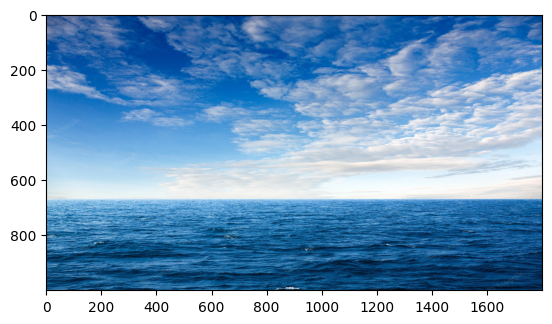

In [2]:
img1 = np.array(Image.open('sky.jpeg'))
img1 = cv2.resize(img1, (1800, 1000))
plt.imshow(img1)

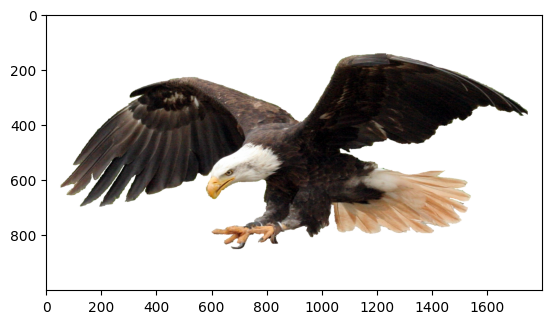

In [3]:
# image 2 (the eagle) has a transparent backgroud
img2 = np.array(Image.open('eagle.png').convert('RGB'))
img2 = cv2.resize(img2, (1800, 1000))
plt.imshow(img2)

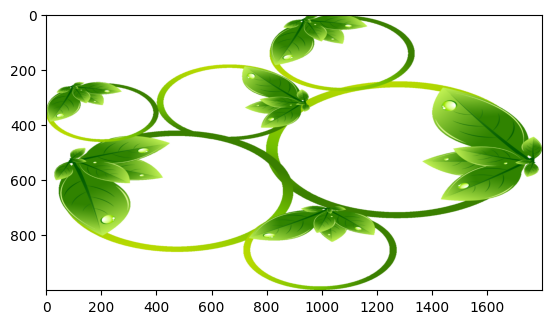

In [4]:

img3 = np.array(Image.open('leaves.png').convert('RGB'))
img3 = cv2.resize(img3, (1800, 1000))
plt.imshow(img3)

In [ ]:
mask_3 = np.array(Image.open('leaves.png').resize((1800,1000)),dtype='float32')[:,:,-1]>0
mask_3 = (1-mask).astype(bool)

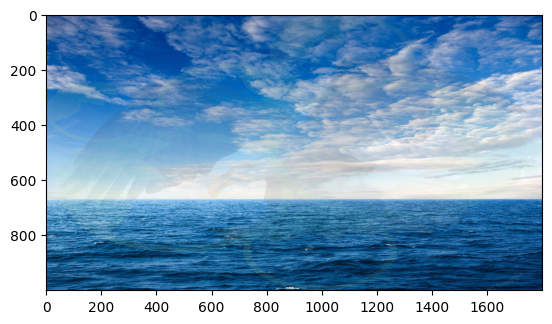

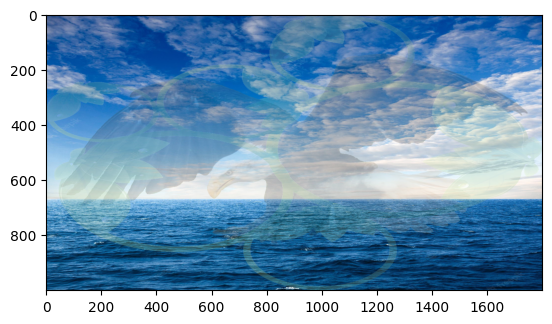

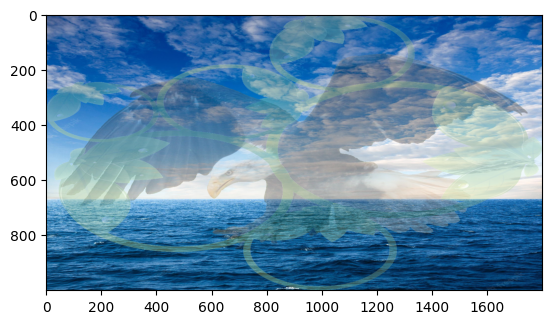

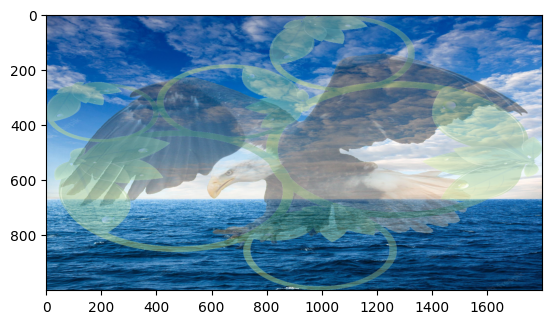

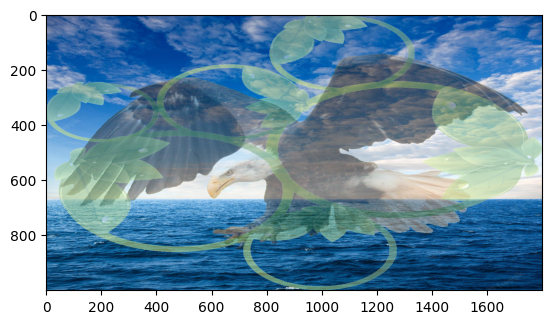

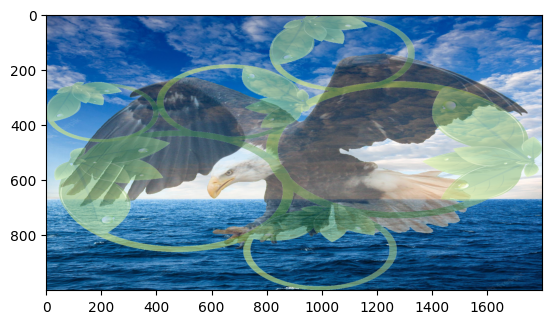

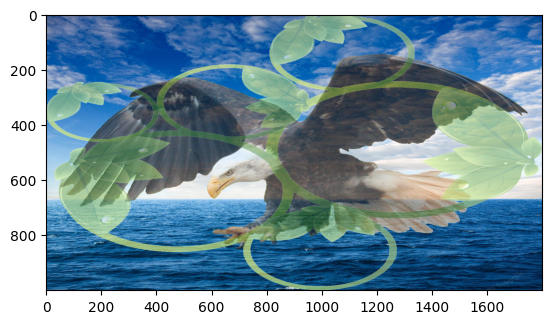

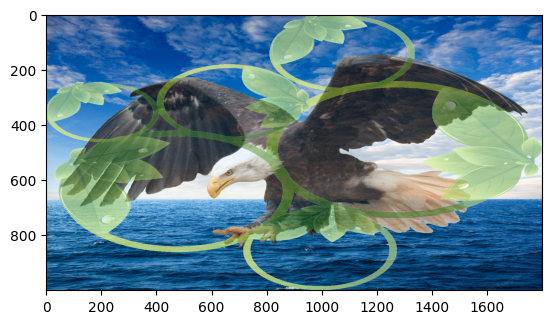

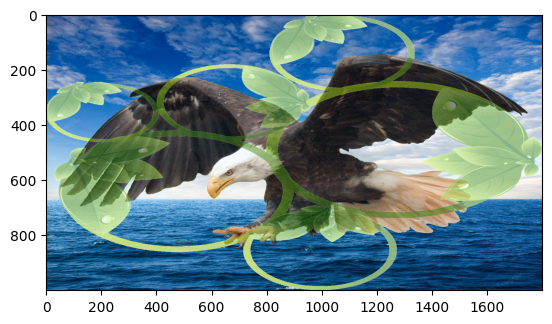

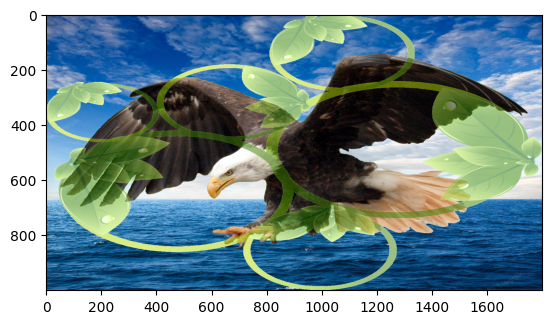

In [13]:
mask_2 = np.array(Image.open('eagle.png').resize((1800,1000)),dtype='float32')[:,:,-1]>0
mask_3 = np.array(Image.open('leaves.png').resize((1800,1000)),dtype='float32')[:,:,-1]>0
mask = mask_2+mask_3
mask = (1-mask).astype(bool)
for i in range(1,11):
    alpha = 0.1*i
    
    # first blending transparent layers
    img_b = cv2.addWeighted(img2,0.5,img3,0.5,0)
    mask_b = (1-mask_3).astype(bool)
    img_b[mask_b]=img2[mask_b]
    
    # then blending top layers to the background
    img_b = cv2.addWeighted(img1,1-alpha,img_b,alpha,0)
    img_b[mask]=img1[mask]
    plt.imshow(img_b)
    plt.show()

## solution2: pyramid blending

In [11]:

# Find the Gaussian pyramid of the two images and the mask
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyr.append(np.float32(lower))
    return gaussian_pyr

# Then calculate the Laplacian pyramid
def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr


# Now blend the two images wrt. the mask
def blend(laplacian_A,laplacian_B,mask_pyr):
    LS = []
    for la,lb,mask in zip(laplacian_A,laplacian_B,mask_pyr):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)
    return LS

# Reconstruct the original image
def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1
    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyr[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst


In [12]:

# Load the two images

img1 = np.array(Image.open('sky.jpeg'))
img1 = cv2.resize(img1, (1800, 1000))

img2 = np.array(Image.open('eagle.png').convert('RGB'))
img2 = cv2.resize(img2, (1800, 1000))


In [13]:
# Create the mask
mask = np.array(Image.open('eagle.png').resize((1800,1000)),dtype='float32')[:,:,-1][:,:,np.newaxis]
mask = np.concatenate((mask,mask,mask),axis=2)
mask[mask>0]=1

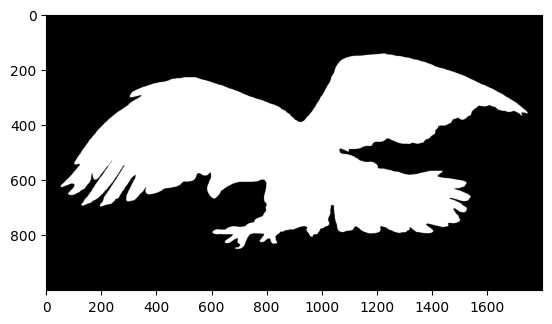

In [14]:
plt.imshow(mask)

In [16]:
num_levels = 7
# For image-1, calculate Gaussian and Laplacian
gaussian_pyr_1 = gaussian_pyramid(img1, num_levels)
laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)
# For image-2, calculate Gaussian and Laplacian
gaussian_pyr_2 = gaussian_pyramid(img2, num_levels)
laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)
# Calculate the Gaussian pyramid for the mask image and reverse it.
mask_pyr_final = gaussian_pyramid(mask, num_levels)

mask_pyr_final.reverse()
# Blend the images
add_laplace = blend(laplacian_pyr_1,laplacian_pyr_2,mask_pyr_final)
final  = reconstruct(add_laplace)

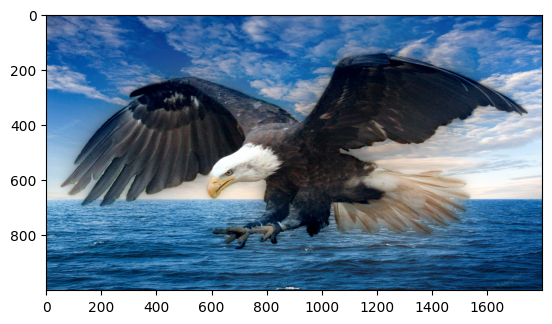

In [17]:
cv2.imwrite('blended.jpg',final[num_levels])
blended = cv2.imread('blended.jpg')
plt.imshow(blended)

## solution3: poisson blending


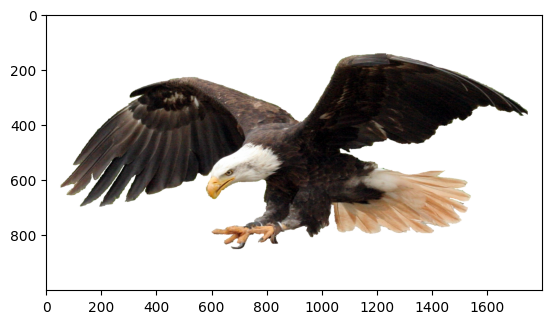

In [32]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
# import imageio
# from google.colab.patches import cv2_imshow

def PoissonImageBlending(source, destination, mask):
    # create an all "White" mask: 255, if black mask is 0
#     mask = 255 * np.ones(destination.shape, destination.dtype) 
    # navigate the source img location
    width, height, channels = source.shape
    center = (height//2, width//2)

    # using built-in funtion `cv2.seamlessClone` to acommpulish Poisson Image
    blended = cv2.seamlessClone(destination, source, mask, center, 2) # cv::MIXED_CLONE = 2
    output = blended
    plt.imshow(output)

source = np.array(Image.open('eagle.png').convert('RGB'))

source = cv2.resize(source, (1800, 1000))
plt.imshow(source)


In [33]:
# Create the mask
mask = np.array(Image.open('eagle.png').resize((1800,1000)))[:,:,-1][:,:,np.newaxis]
mask = np.concatenate((mask,mask,mask),axis=2)
mask[mask==1]=255

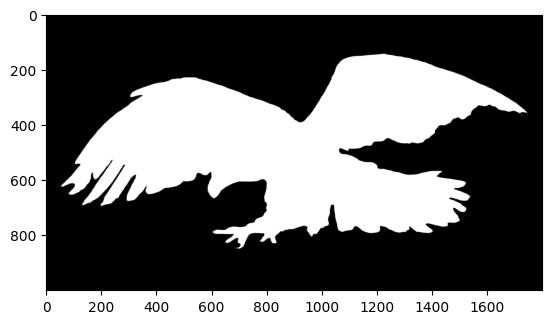

In [34]:
plt.imshow(mask)

In [35]:
destination = np.array(Image.open('sky.jpeg'))
destination = cv2.resize(destination, (1800, 1000))

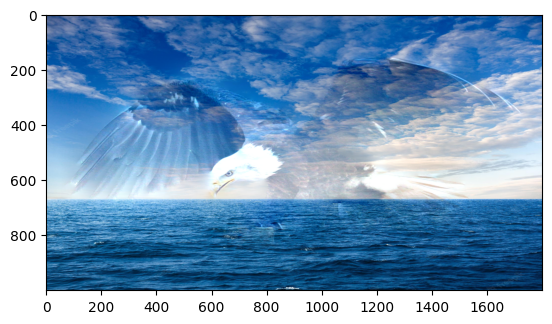

In [36]:
# blended image 
PoissonImageBlending(destination,source,mask)

## solution4: deep learning model
By carefully tuning the hyperparameters, the deep learning model we applied before can perform as below.

In [37]:
blended = Image.open('7_first_pass.png')

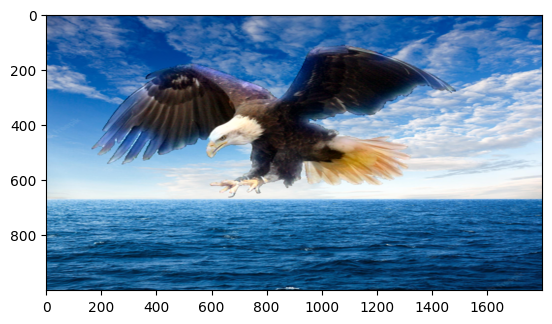

In [38]:
plt.imshow(blended.resize((1800,1000)))